# Temporal evaluation of the SCF param with HMASR 100/30 km
## fig07

Full analyses: https://github.com/mickaellalande/PhD/blob/master/SCF_parameterizations/2_calibration/HMASR_100km_calibration.ipynb  
Original notebook: https://github.com/mickaellalande/PhD/blob/master/SCF_parameterizations/2_calibration/fig_HMASR_100_30km_temp_params_v0.ipynb

conda env: `phd_v3`

In [13]:
# To reload external files automatically (ex: utils)
# phd_v3 env
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
plot.rc['abc.style'] = '(a)' # for EGU journals (only abc in new proplot versions)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Load data

In [14]:
resolutions = ['100km', '30km']
dim = len(resolutions)
sd_list = [None]*dim
swe_list = [None]*dim
scf_list = [None]*dim
mask_list = [None]*dim
topo_list = [None]*dim
topo_std_list = [None]*dim

for i, res in enumerate(resolutions):
    path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_'+res+'/'
    
    # Snow depth
    ds = xr.open_mfdataset(path+'HMA_SR_D_v01_'+res+'_WY*_SD_POST.nc')
    sd_list[i] = ds.SD_Post.load()

    # SCF
    ds = xr.open_mfdataset(path+'HMA_SR_D_v01_'+res+'_WY*_SWE_SCA_POST.nc')
    swe_list[i] = ds.SWE_Post.load()
    scf_list[i] = ds.SCA_Post.load()

    # Mask
    mask_list[i] = xr.open_dataarray('Non_seasonal_snow_mask_'+res+'.nc').load()
    mask_list[i]['lat'] = ds.lat # slight different round
    mask_list[i]['lon'] = ds.lon
    
    if res == '100km':
        # Topo
        latlim = slice(mask_list[i].lat.min().values.item(0)-0.5, mask_list[i].lat.max().values.item(0)+0.5)
        lonlim = slice(mask_list[i].lon.min().values.item(0)-0.5, mask_list[i].lon.max().values.item(0)+0.5)
        

    ds_topo = xr.open_dataset('../data/HMASR_DEM_'+res+'.nc')
    ds_topo['lat'] = ds.lat # slight different round
    ds_topo['lon'] = ds.lon
    topo_list[i] = ds_topo.elevation_seassnow.load()
    topo_std_list[i] = ds_topo.std_seassnow.load()
    
train_period = slice('1999-10-01', '2013-09-30') # ~80%
val_period = slice('2013-10-01', '2017-09-30') # ~20%

In [15]:
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

def plot_hatches_mask(ax, mask):
    mask_lats = []
    mask_lons = []

    threshold = 30
    delta = ((mask.lat[1]-mask.lat[0])/2).item(0)
    
    for lat in mask.lat.values:
        for lon in mask.lon.values:
            temp = mask.where(mask>threshold)*0+1
            if temp.sel(lat=lat, lon=lon) == 1:
                mask_lats.append(lat)
                mask_lons.append(lon)
    
    for i in range(len(mask_lats)):
        ax.add_patch(
                mpatches.Rectangle(
                    xy=[mask_lons[i]-delta, mask_lats[i]-delta], width=1, height=2*delta, transform=ccrs.PlateCarree(),
                    fill=False, zorder=10, color='black', linewidth=0, hatch='//////',
                )
            )

In [16]:
weights_list = [None]*dim
for i in range(2):
    lat_weights = np.cos(np.deg2rad(scf_list[i].lat))
    frac_seasonal_snow = (1-mask_list[i]/100).where(scf_list[i][0]*0+1 == 1)
    temp = (frac_seasonal_snow*lat_weights).where(mask_list[i]<30)
    weights = (temp / temp.sum()).fillna(0)
    np.testing.assert_almost_equal(weights.sum().values.item(0), 1)
    weights_list[i] = weights

### Check zones

In [17]:
# Get zone limits for annual cycle
lonlim_TS, latlim_TS, lonlim_HK, latlim_HK, lonlim_TP, latlim_TP, lonlim_HM, latlim_HM = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'TS', 'HK', 'TP', 'HM']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_TS, latlim_TS], [lonlim_HK, latlim_HK], [lonlim_TP, latlim_TP], [lonlim_HM, latlim_HM]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

## SCF params

In [18]:
# R01
def R01(swe, zstd):
    return 0.95 * np.tanh(100*swe) * np.sqrt( 1000*swe / ( 1000*swe + 0.15*zstd + 1e-6) )

# NY07
def NY07(sd, z0, rho_snow, rho_new, m, mask, swe):
    scf = np.tanh(sd/(2.5*z0*(rho_snow/rho_new)**m))
    return scf.where((sd>1e-7) & (swe>1e-7) & (rho_snow<917), other=0).where( (sd*0+1) == 1).where(mask < 30)

# SL12
def SL12(swe, topo_std, scf):
    
    # Initialize with first SCF
    temp = scf.copy()
    temp[1:] = np.nan 
    
    N_melt = 200 / topo_std.where(topo_std > 10, other=10) # eq. (5) in SL12 (modified)
    swe_max = ( 2. * swe[0] ) / ( 1 + np.cos( np.pi * (1 - temp[0])**(1/N_melt) ) )

    for i_time in range(swe.time.size-1):
#         print(i_time)

        delta_swe = swe[i_time+1]-swe[i_time]
                
        melt = (1 - ( 1 / np.pi * np.arccos( 2 * (swe[i_time+1] / swe_max).where(swe[i_time+1] / swe_max < 1) - 1 ) )**N_melt)

        k = 0.1 # 0.1 in SL12
        accu = (1 - ( 1 - (k*delta_swe*1e3).where(k*delta_swe*1e3 < 1, 1).where(delta_swe*0+1 == 1) ) * ( 1. - temp[i_time] ))
        total = accu.where( (delta_swe > 1e-6), melt)
        temp[i_time+1] = total.where(total > 0, 0).where(scf[0]*0+1 == 1) 
        
        swe_max = ( ( 2. * swe[i_time+1] ) / ( 1 + np.cos( np.pi * (1 - temp[i_time+1])**(1/N_melt) ) ) ).where(delta_swe > 1e-6, swe_max)
    
    return temp

# LA22
def LA22(sd, z0, rho_snow, rho_new, m, zstd, zstd_0, m2, mask, swe):
    scf = np.tanh(sd/(2.5*z0*(rho_snow/rho_new)**m + zstd_0*zstd*(rho_snow/rho_new)**m2 ))
    return scf.where((sd>1e-7) & (swe>1e-7) & (rho_snow<917), other=0).where( (sd*0+1) == 1).where(mask < 30)


scf_R01_list = [None]*2
scf_NY07_list = [None]*2
scf_SL12_list = [None]*2
scf_LA22_list = [None]*2
scf_DNN_list = [None]*2
for i in range(2):
    scf_R01_list[i] = R01(swe_list[i], topo_std_list[i])
    scf_NY07_list[i] = NY07(sd_list[i], 0.01, swe_list[i]/sd_list[i]*1000, 50, 1, mask_list[i], swe_list[i])
    scf_SL12_list[i] = SL12(swe_list[i], topo_std_list[i], scf_list[i])
    scf_LA22_list[i] = LA22(sd_list[i], 0.01, swe_list[i]/sd_list[i]*1000, 50, 1, topo_std_list[i], 3e-6, 3, mask_list[i], swe_list[i])


# DNN
scf_DNN_list[0] = xr.open_dataarray('results/scf_100km_ML3.nc')
scf_DNN_list[1] = xr.open_dataarray('/home/lalandmi/Dropbox/data/SCF_parameterizations/2_calibration/results/scf_30km_ML3.nc')


## Spatial bias

In [19]:
import warnings
warnings.filterwarnings("ignore")

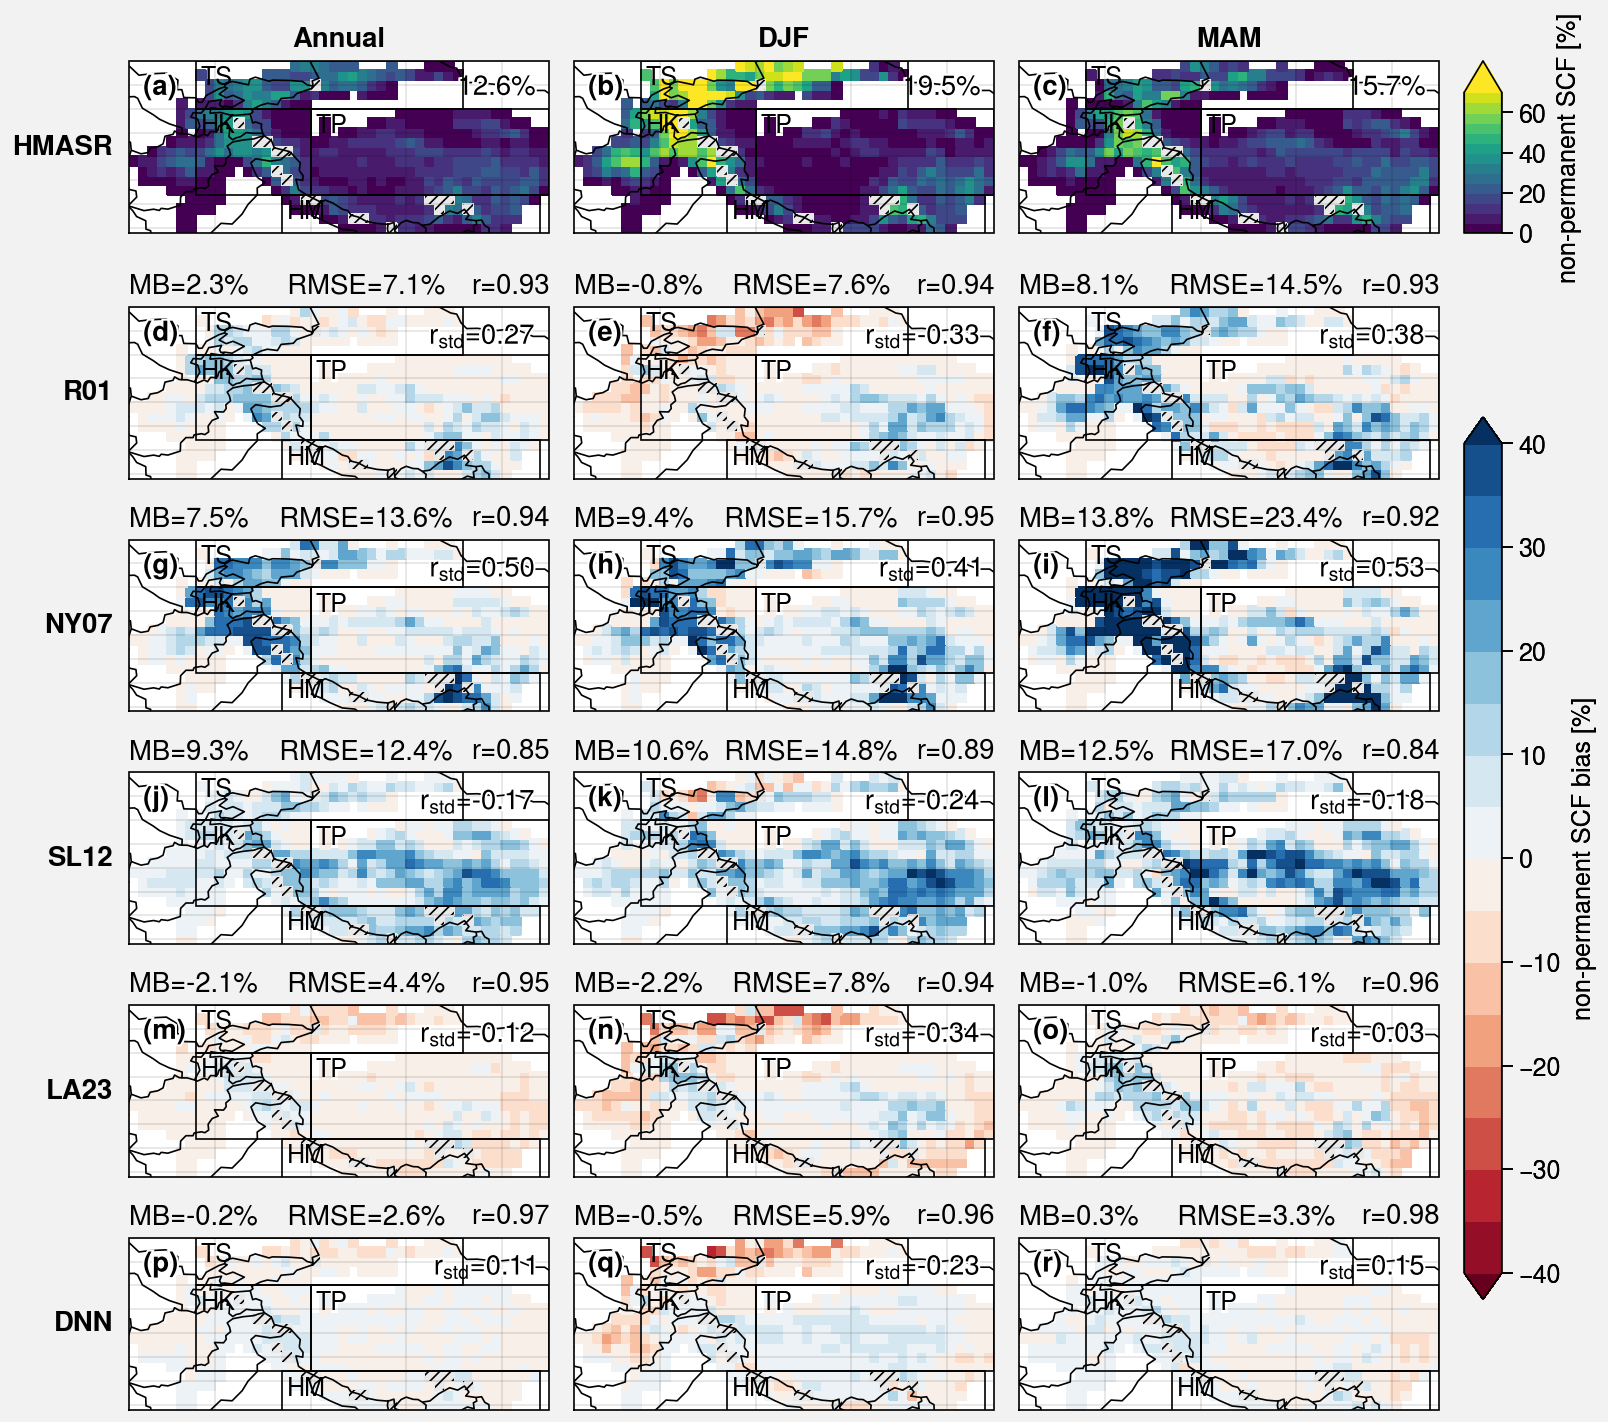

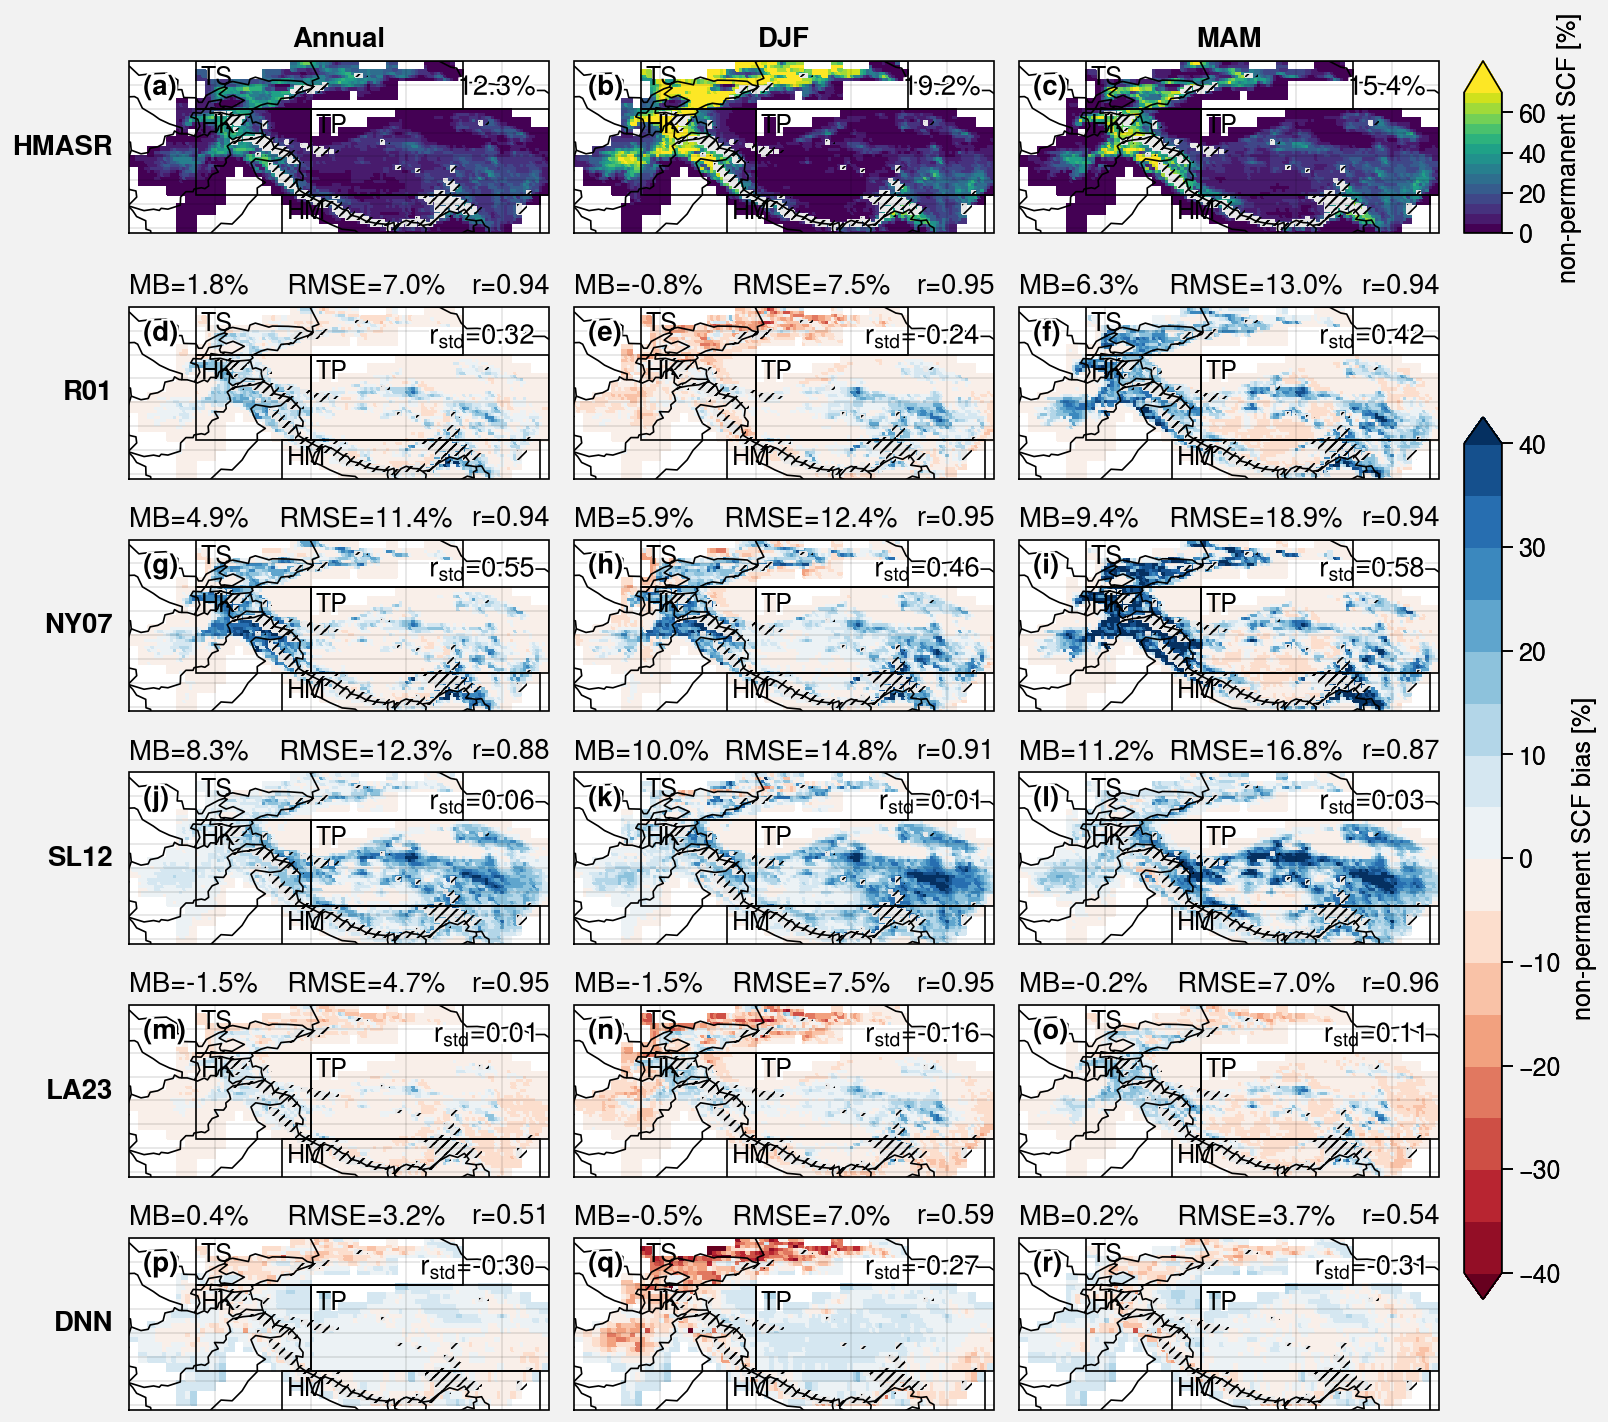

In [20]:
seasons=['Annual', 'DJF', 'MAM']; freq='D'
levels=plot.arange(0, 70, 5); extend='max'; cmap='viridis'
levels_bias=plot.arange(-40, 40, 5); extend_bias='both'; cmap_bias='RdBu'
threshold=30 # percentage of permanent snow in a cell
params = ['R01', 'NY07', 'SL12', 'LA23', 'DNN']

for scf_params, scf, weights, topo_std, topo, mask in zip(
    [[scf_R01_list[0], scf_NY07_list[0], scf_SL12_list[0], scf_LA22_list[0], scf_DNN_list[0]],
        [scf_R01_list[1], scf_NY07_list[1], scf_SL12_list[1], scf_LA22_list[1], scf_DNN_list[1]]],
    scf_list, weights_list, topo_std_list, topo_list, mask_list
):


    fig, axs = plot.subplots(proj='cyl', ncols=len(seasons), nrows=len(params)+1, axwidth=2.1)

    # HMASR
    scf_ref_seasons = []
    for i, season in enumerate(seasons):
        data = u.clim(scf.sel(time=val_period), freq=freq, season=season, skipna=True)*100
        scf_ref_seasons.append(data)
        m = axs[0, i].pcolormesh(data, levels=levels, extend=extend, cmap=cmap)
        axs[0, i].format(urtitle='{:.1f}%'.format(data.weighted(weights).sum().values.item(0)))

    # bias
    for j, param in enumerate(params):
        for i, season in enumerate(seasons):
            scf_param_clim = u.clim(scf_params[j].sel(time=val_period), freq=freq, season=season, skipna=True)*100

            bias = scf_param_clim-scf_ref_seasons[i]
            m_bias = axs[j+1, i].pcolormesh(bias, levels=levels_bias, extend=extend_bias, cmap=cmap_bias)

            mb = u.weighted_mean(bias, weights).values.item(0)
            rmse = u.weighted_rmse(scf_param_clim, scf_ref_seasons[i], weights).values.item(0)
            r = u.weighted_corr(scf_param_clim, scf_ref_seasons[i], weights).values.item(0)
            r_std = u.weighted_corr(bias, topo_std, weights).values.item(0)
            r_topo = u.weighted_corr(bias, topo, weights).values.item(0)
            axs[j+1, i].format(
                ltitle='MB={:.1f}%'.format(mb), ctitle='       RMSE={:.1f}%'.format(rmse), rtitle='r={:.2}'.format(r),
                urtitle='$r_{std}$'+'={:.2f}'.format(r_std)
            )

    # mask
    for ax in axs:
        ax.pcolormesh(mask.where(mask>threshold)*0+1, cmap='lightgray', levels=[0, 1, 2, 3])
        plot_hatches_mask(ax, mask)
        u.plot_zones(ax=ax)
    #     ax.format(utitle='aze')

    # Colorbars
    fig.colorbar(m, label='non-permanent SCF [%]', row=1, ticks=20)
    fig.colorbar(m_bias, label='non-permanent SCF bias [%]', rows=(2, 6), ticks=10, length=0.8)

    # Format
    axs.format(
        borders=True, labels=False, 
        latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    #     suptitle=param+' daily non-permanent SCF at 1°x1° predicted from HMASR inputs\n(1999-10-01 to 2017-09-30; grid cells with >30% permanent snow are excluded)',
        abc=True, abcloc='ul',
        collabels=seasons,
        rowlabels=['HMASR'] + params
    )


## Time series

In [21]:
column_indexes = [['val_100', 'val_30'], ['HMASR', 'R01', 'NY07', 'SL12', 'LA23', 'DNN']]
columns = pd.MultiIndex.from_product(column_indexes)

row_indexes = [zones, ['mb', 'rmse', 'r', 'std']]
rows = pd.MultiIndex.from_product(row_indexes)

df_metrics = pd.DataFrame(index=rows, columns=columns)
df_metrics

val_100                          val_30                         
           HMASR  R01 NY07 SL12 LA23  DNN  HMASR  R01 NY07 SL12 LA23  DNN
HMA mb       NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
    rmse     NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
    r        NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
    std      NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
TS  mb       NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
    rmse     NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
    r        NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
    std      NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
HK  mb       NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
    rmse     NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
    r        NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
    std      NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
TP  mb       NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
    rmse     NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
    r        NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
    std      NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
HM  mb       NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
    rmse     NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
    r        NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN
    std      NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN

## Compute metrics for both resolutions and plot time series

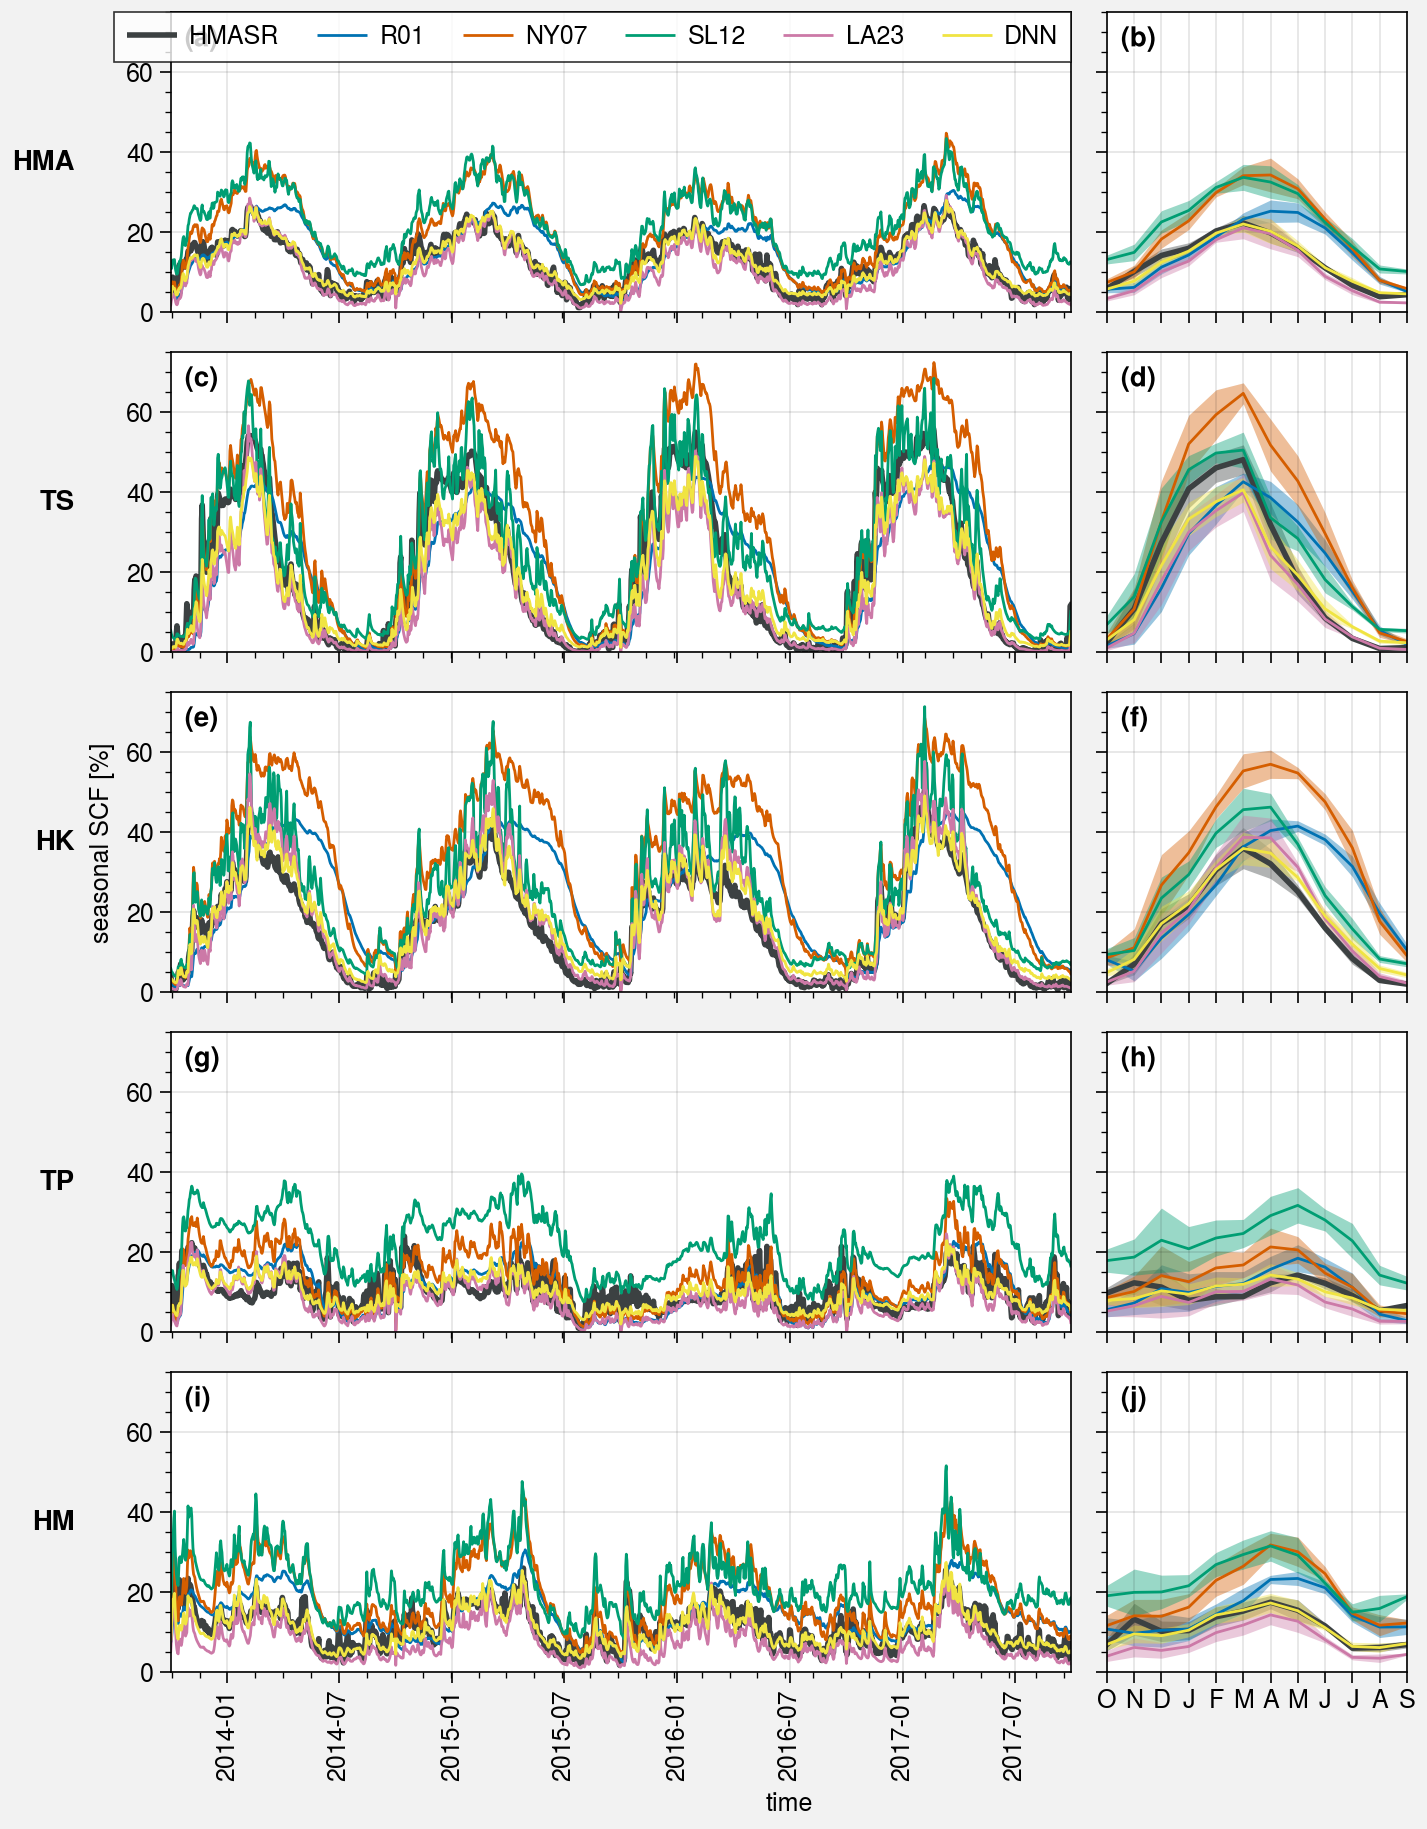

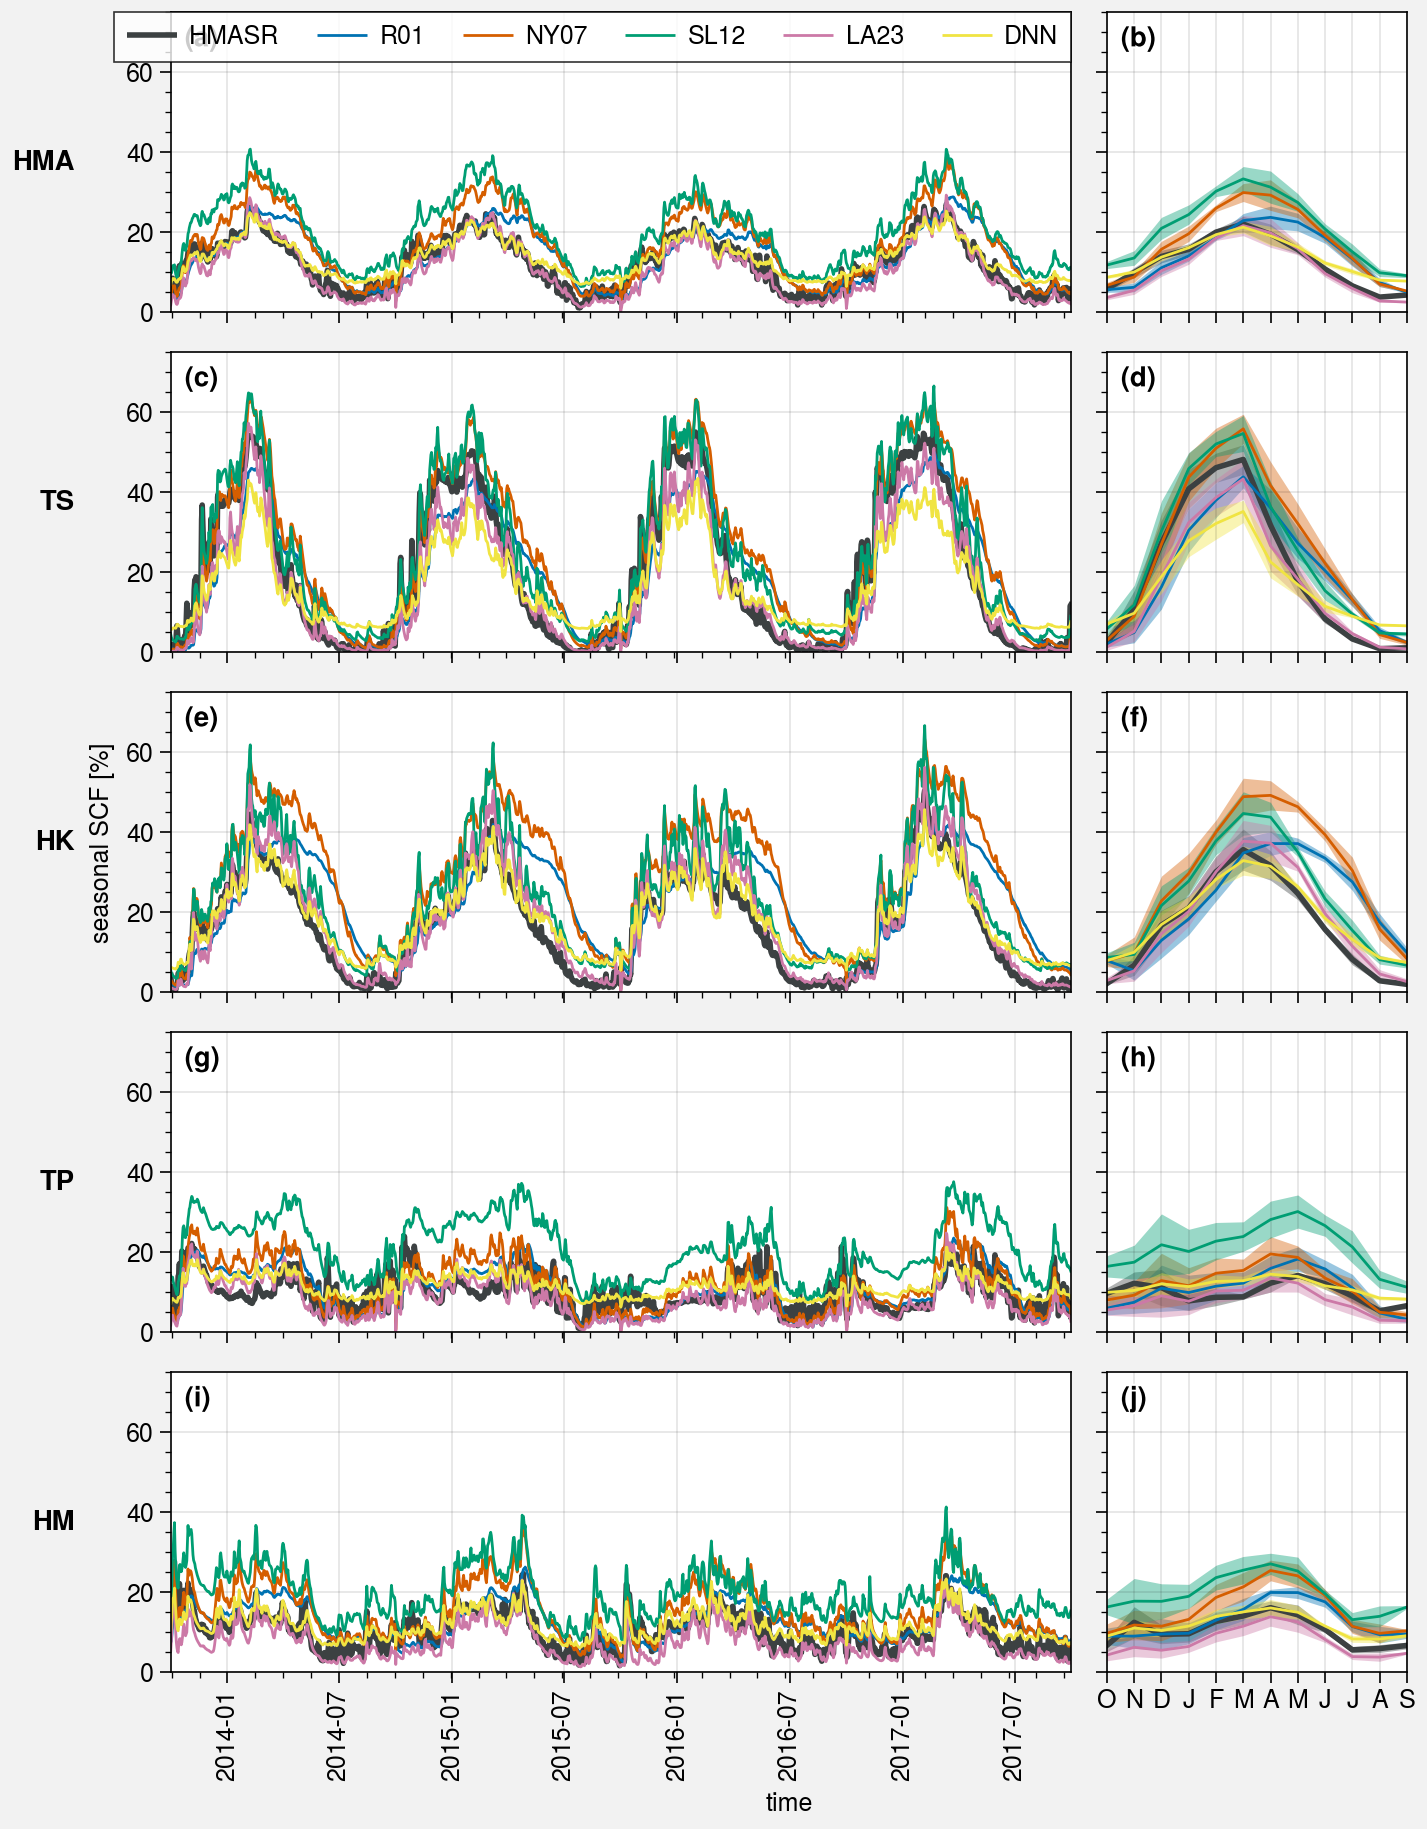

In [36]:
zones = ['HMA', 'TS', 'HK', 'TP', 'HM']


labels = ['HMASR', 'R01', 'NY07', 'SL12', 'LA23', 'DNN']
plot.rc.cycle = 'colorblind'
colors = ['charcoal gray', 'C0', 'C1', 'C2', 'C3', 'C4']
linewidths = [2, 1, 1, 1, 1, 1]


for list_scf, scf, weights, topo_std, topo, mask, metric_label in zip(
    [[scf_list[0], scf_R01_list[0], scf_NY07_list[0], scf_SL12_list[0], scf_LA22_list[0], scf_DNN_list[0]],
        [scf_list[1], scf_R01_list[1], scf_NY07_list[1], scf_SL12_list[1], scf_LA22_list[1], scf_DNN_list[1]]],
    scf_list, weights_list, topo_std_list, topo_list, mask_list, ['val_100', 'val_30']
):

    fig, axs = plot.subplots(nrows=len(zones), ncols=2, axwidth=4.5, ref=1, wratios=(3, 1), aspect=3)

    ###################
    ### Time series ###
    ###################
    for i, zone in enumerate(zones):
        ax = axs[i, 0]
        ts_ref = scf.sel(lat=zones_df.loc[zone].latlim, lon=zones_df.loc[zone].lonlim).weighted(weights).mean(('lat', 'lon'))*100

        for j, da in enumerate(list_scf):
            ts = da.sel(lat=zones_df.loc[zone].latlim, lon=zones_df.loc[zone].lonlim, time=val_period).weighted(weights).mean(('lat', 'lon'))*100
            ax.plot(ts, label=labels[j], color=colors[j], linewidth=linewidths[j])

            # Compute metrics
            ts = da.sel(lat=zones_df.loc[zone].latlim, lon=zones_df.loc[zone].lonlim, time=val_period).weighted(weights).mean(('lat', 'lon'))*100

            mb = ( ts - ts_ref.sel(time=val_period) ).mean().item(0)
            rmse = np.sqrt( ( ( ts - ts_ref.sel(time=val_period) )**2 ).mean().item(0) )
            r = stats.pearsonr(ts, ts_ref.sel(time=val_period))[0]
            std = ts.std().item(0)

            df_metrics.loc[(zone), (metric_label, labels[j])]  = [mb, rmse, r, std]


    axs[0].legend(ncol=6)

    ####################
    ### Annual cycle ###
    ####################
    for i, zone in enumerate(zones):
            ax = axs[i, 1]

            ac_list = []
            for j, da in enumerate(list_scf):
                ac = da.sel(lat=zones_df.loc[zone].latlim, lon=zones_df.loc[zone].lonlim, time=val_period) \
                            .groupby('time.month').mean() \
                            .weighted(weights).mean(('lat', 'lon'))*100
                std = da.sel(lat=zones_df.loc[zone].latlim, lon=zones_df.loc[zone].lonlim, time=val_period) \
                            .weighted(weights).mean(('lat', 'lon')) \
                            .resample(time='M').mean() \
                            .groupby('time.month').std()*100

                ac_list.append(ac)

                ac_shift = ac.reindex(month=np.roll(ac.month,4))
                std_shift = std.reindex(month=np.roll(std.month,4))
                shadedata = [(ac_shift-std_shift).values, (ac_shift+std_shift).values]

                ax.plot(ac_shift.values, shadedata=shadedata, label='SCF', linewidth=linewidths[j], color=colors[j])

            ax.format(
                xlocator='index', xformatter=[cld.month_abbr[month][0] for month in ac.reindex(month=np.roll(ac.month,3)).month.values],
            )




    for ax in axs:
        ax.autoscale(tight=True)

    axs.format(
        rowlabels=zones,
        abc=True, abcloc='ul',
        ylim=(0, 75), ylabel='seasonal SCF [%]',
    )


# fig.save('img/timeseries_ac_1deg.jpg')

In [37]:
df_metrics

val_100                                                     val_30  \
            HMASR       R01      NY07      SL12      LA23       DNN    HMASR   
HMA mb          0   2.34397   7.47849    9.3384  -2.13778  -0.20919        0   
    rmse        0   5.46397   9.17444   9.90974   2.82484   1.50833        0   
    r           1  0.768814   0.91929  0.953486  0.964685  0.973764        1   
    std   6.56392     7.643   10.6783    8.9199   6.98037   6.37782   6.4859   
TS  mb          0  0.865556   10.8894   5.19973  -4.64104  -2.25687        0   
    rmse        0   10.1078   14.0924   6.96517   6.96153   5.29833        0   
    r           1  0.832757  0.935583  0.967174  0.972206  0.983264        1   
    std   18.1896   15.2184   23.2438   17.9259   14.7196   14.4215  18.2414   
HK  mb          0   7.52558   16.9778   7.95244   1.36486   1.88668        0   
    rmse        0   12.5261   19.5356   9.26764   3.88184   2.96725        0   
    r           1  0.696146  0.886729  0.964789  0.972222   0.98317        1   
    std    12.462   13.1731   18.8096   15.4734   14.2833   12.0042   12.325   
TP  mb          0  0.584592   3.06617   12.2891  -2.24349 -0.180442        0   
    rmse        0   4.51073   5.75434   13.4014   3.97573   2.91213        0   
    r           1  0.669591  0.735522  0.746207  0.739523  0.746731        1   
    std   4.28437   6.01187   7.06092   7.71804   4.73559   3.77154  4.26518   
HM  mb          0   3.74366   8.07647   11.3426  -3.58826 -0.341955        0   
    rmse        0   5.89255   9.46122   11.9243   4.20894    2.0534        0   
    r           1   0.65809  0.856977  0.879391  0.898869  0.915069        1   
    std   5.01499   5.83982   8.49365   7.20919   4.60696   4.68336   4.6644   

                                                            
               R01      NY07      SL12      LA23       DNN  
HMA mb     1.76021   4.87333   8.29945  -1.53917   1.25117  
    rmse   4.50584   6.24368   8.89388   2.40012   2.47266  
    r     0.816836  0.928703  0.960261  0.965715  0.972324  
    std    7.08825   9.09749   8.86316   7.00951   4.80562  
TS  mb    0.157613   5.55965   4.81484  -3.12375  -2.81046  
    rmse   8.20308   8.01868   5.69492    5.4262   8.64079  
    r     0.896733  0.955477   0.98773  0.976528  0.978025  
    std    14.9119   19.5314   19.0824    15.752   10.6086  
HK  mb     5.86597   12.5636   7.06866   1.67955   2.13043  
    rmse   10.4602   14.5143   7.98281   3.70395   3.97444  
    r     0.743121  0.901472  0.977043  0.972388  0.983256  
    std    11.8022   16.0466   14.6621    13.605   9.62609  
TP  mb    0.753008   2.08182   11.2501  -1.85841   1.55483  
    rmse   4.30071   4.83555   12.4235   3.74094    3.3095  
    r     0.682185    0.7342  0.730902  0.743656  0.736713  
    std    5.77379   6.39693   7.51129   4.72415   2.67635  
HM  mb     2.44287   5.16678   9.22774  -2.81336   1.24507  
    rmse   4.40526   6.32108   9.67931   3.49479     2.431  
    r     0.710837  0.861947  0.893786  0.896625    0.9079  
    std    4.95131   6.78959   6.20897   4.36353   3.50235

## Make time series only for 1° resolution

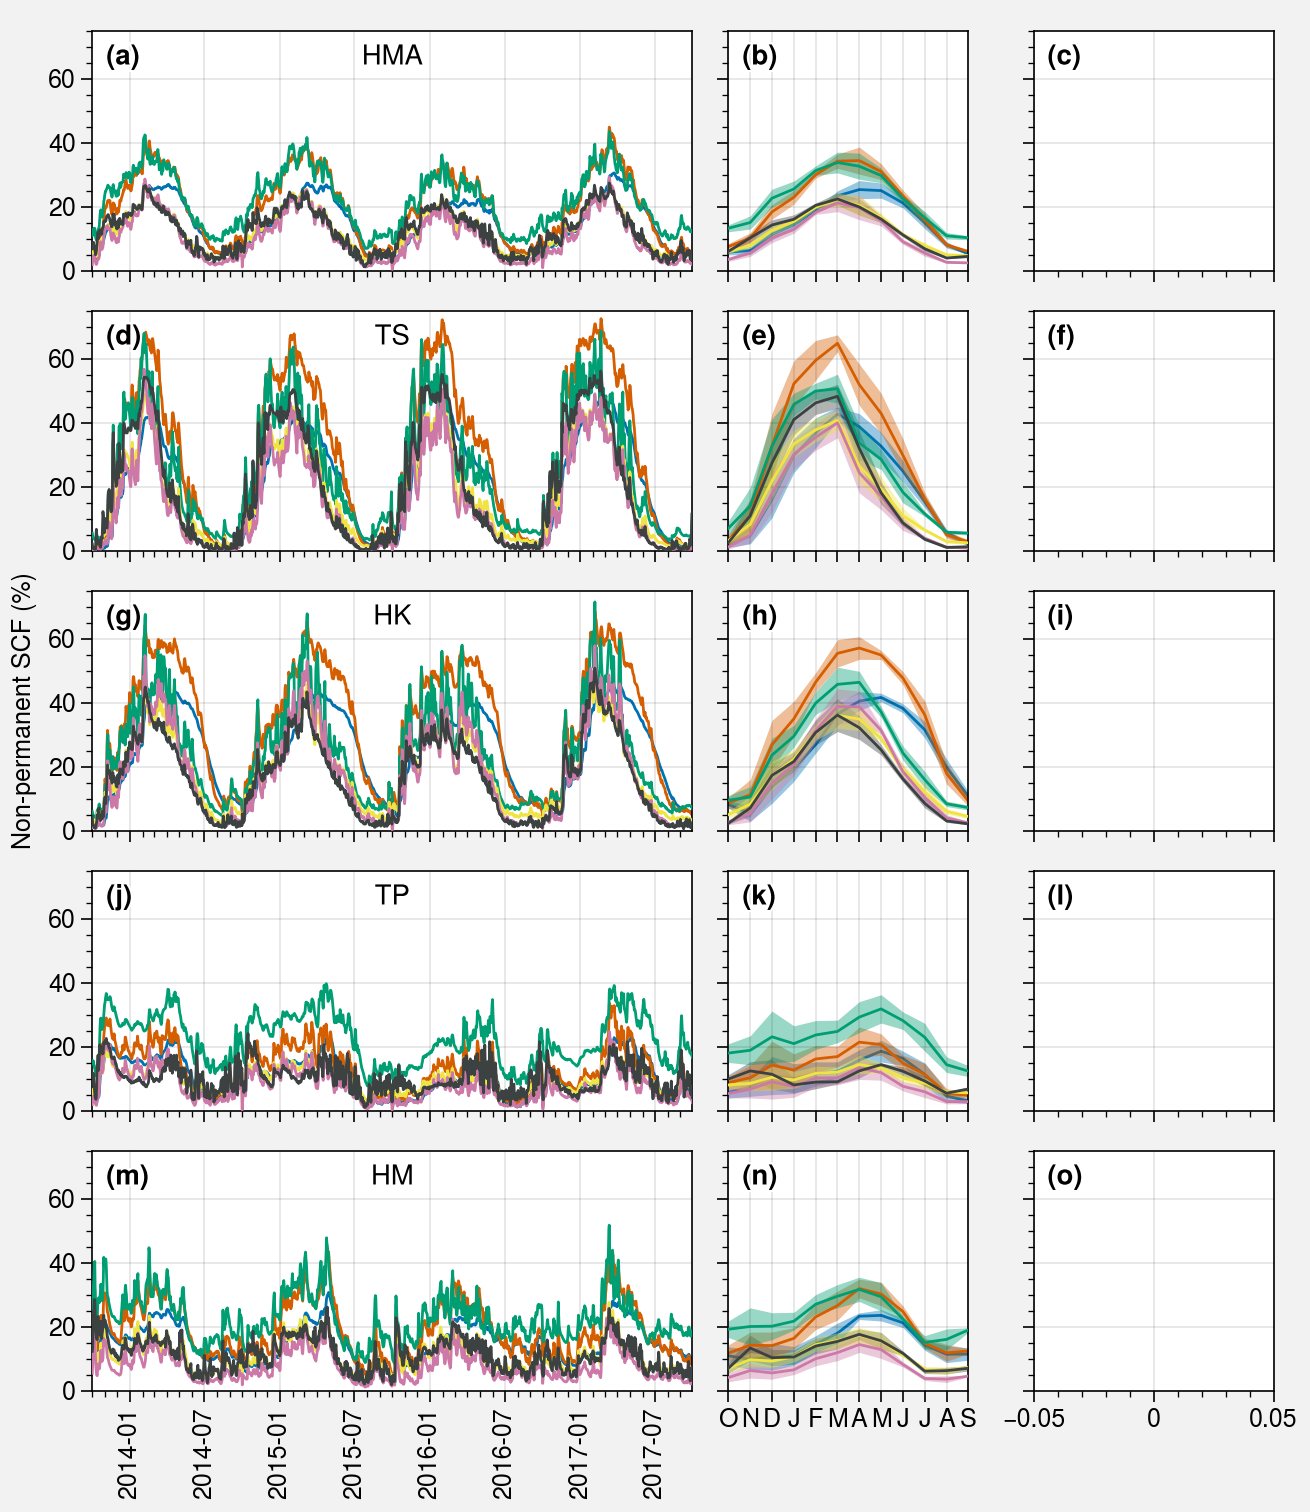

In [47]:
zones = ['HMA', 'TS', 'HK', 'TP', 'HM']


labels = ['HMASR', 'R01', 'NY07', 'SL12', 'LA23', 'DNN']
plot.rc.cycle = 'colorblind'
colors = ['charcoal gray', 'C0', 'C1', 'C2', 'C3', 'C4']
linewidths = [1, 1, 1, 1, 1, 1]
zorders = [6, 1, 2, 3, 5, 4]


list_scf, scf, weights, topo_std, topo, mask, metric_label = \
    [scf_list[0], scf_R01_list[0], scf_NY07_list[0], scf_SL12_list[0], scf_LA22_list[0], scf_DNN_list[0]], \
    scf_list[0], weights_list[0], topo_std_list[0], topo_list[0], mask_list[0], ['val_100']

fig, axs = plot.subplots(nrows=len(zones), ncols=3, axwidth=3, ref=1, wratios=(2.5, 1, 1), aspect=2.5, hspace=0.2)

###################
### Time series ###
###################
for i, zone in enumerate(zones):
    ax = axs[i, 0]
    ts_ref = scf.sel(lat=zones_df.loc[zone].latlim, lon=zones_df.loc[zone].lonlim).weighted(weights).mean(('lat', 'lon'))*100

    for j, da in enumerate(list_scf):
        ts = da.sel(lat=zones_df.loc[zone].latlim, lon=zones_df.loc[zone].lonlim, time=val_period).weighted(weights).mean(('lat', 'lon'))*100
        ax.plot(ts, label=labels[j], color=colors[j], linewidth=linewidths[j], zorder=zorders[j])

        # Compute metrics
        ts = da.sel(lat=zones_df.loc[zone].latlim, lon=zones_df.loc[zone].lonlim, time=val_period).weighted(weights).mean(('lat', 'lon'))*100

        mb = ( ts - ts_ref.sel(time=val_period) ).mean().item(0)
        rmse = np.sqrt( ( ( ts - ts_ref.sel(time=val_period) )**2 ).mean().item(0) )
        r = stats.pearsonr(ts, ts_ref.sel(time=val_period))[0]
        std = ts.std().item(0)

        df_metrics.loc[(zone), (metric_label, labels[j])]  = [mb, rmse, r, std]
        
    ax.format(uctitle=zone, xminorlocator='month')


#     axs[0].legend(ncol=6)

####################
### Annual cycle ###
####################
for i, zone in enumerate(zones):
        ax = axs[i, 1]

        ac_list = []
        for j, da in enumerate(list_scf):
            ac = da.sel(lat=zones_df.loc[zone].latlim, lon=zones_df.loc[zone].lonlim, time=val_period) \
                        .groupby('time.month').mean() \
                        .weighted(weights).mean(('lat', 'lon'))*100
            std = da.sel(lat=zones_df.loc[zone].latlim, lon=zones_df.loc[zone].lonlim, time=val_period) \
                        .weighted(weights).mean(('lat', 'lon')) \
                        .resample(time='M').mean() \
                        .groupby('time.month').std()*100

            ac_list.append(ac)

            ac_shift = ac.reindex(month=np.roll(ac.month,4))
            std_shift = std.reindex(month=np.roll(std.month,4))
            shadedata = [(ac_shift-std_shift).values, (ac_shift+std_shift).values]

            ax.plot(ac_shift.values, shadedata=shadedata, label='SCF', linewidth=linewidths[j], color=colors[j], zorder=zorders[j])

        ax.format(
            xlocator='index', xformatter=[cld.month_abbr[month][0] for month in ac.reindex(month=np.roll(ac.month,3)).month.values],
        )




for ax in axs:
    ax.autoscale(tight=True)

axs.format(
#     rowlabels=zones,
    abc=True, abcloc='ul',
    ylim=(0, 75), ylabel='Non-permanent SCF (%)',
    xlabel=''
)

fig.save('img/fig07_1.pdf')

## Taylor diagrams

Modification of `/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/matplotlib/axes/_subplots.py

```python
if len(args) == 1 and type(args[0]) is int:
    
elif len(args) == 3 or type(args[0]) is tuple:
    if type(args[0]) is tuple:
         args = args[0]

```

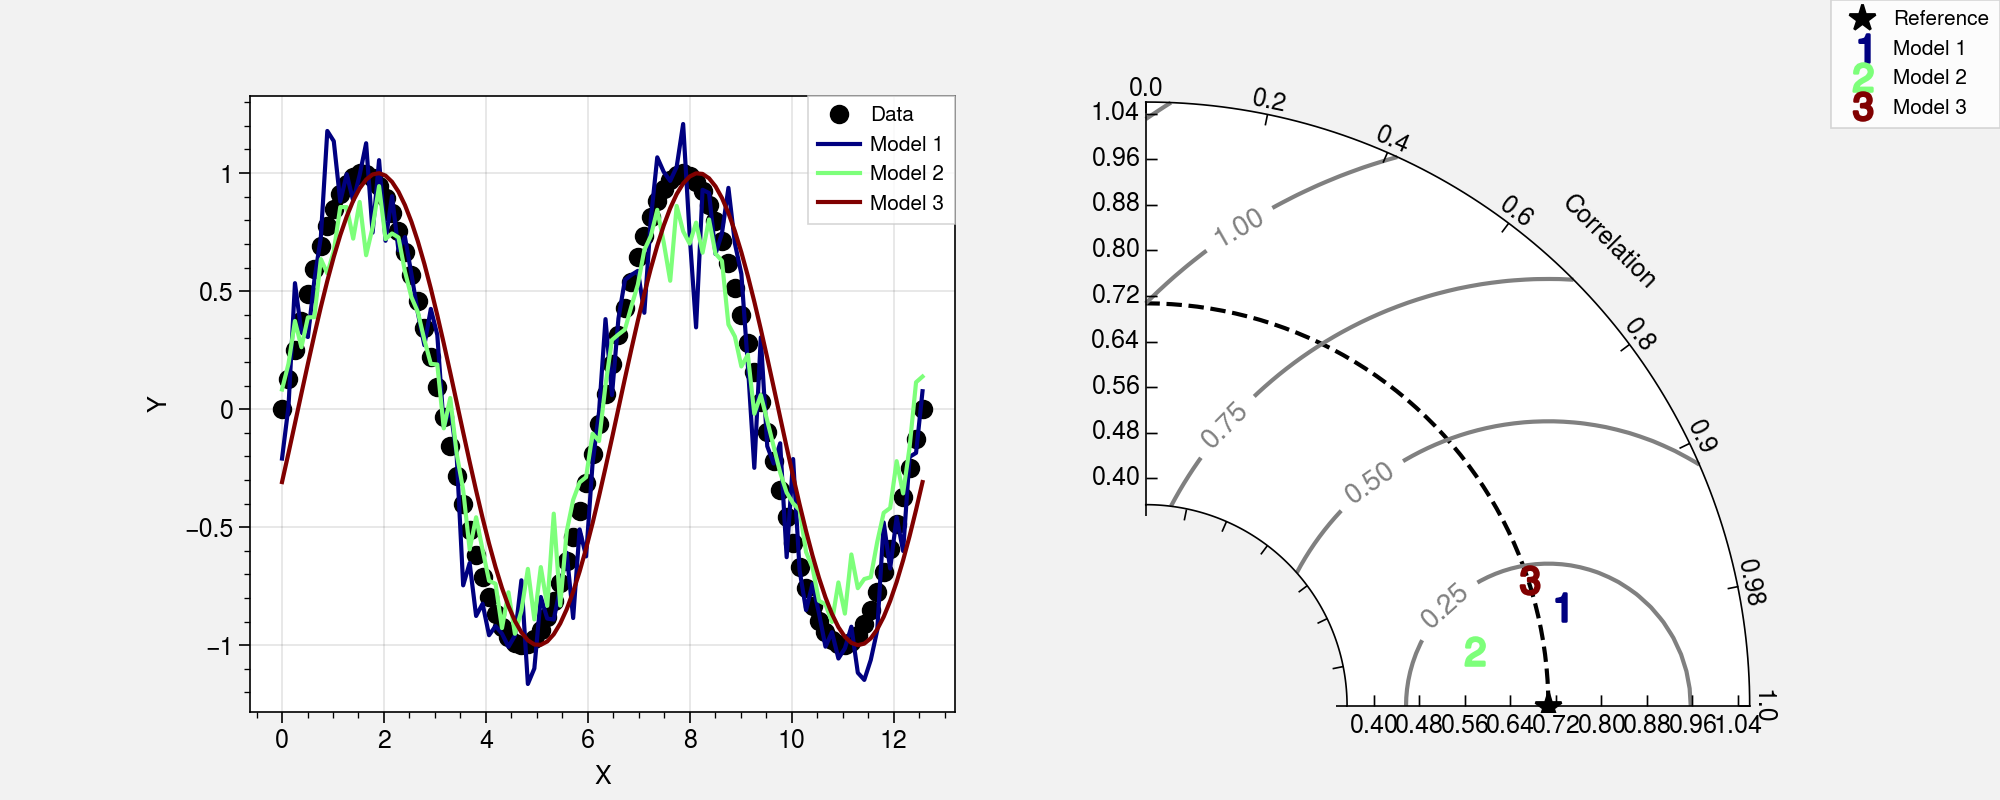

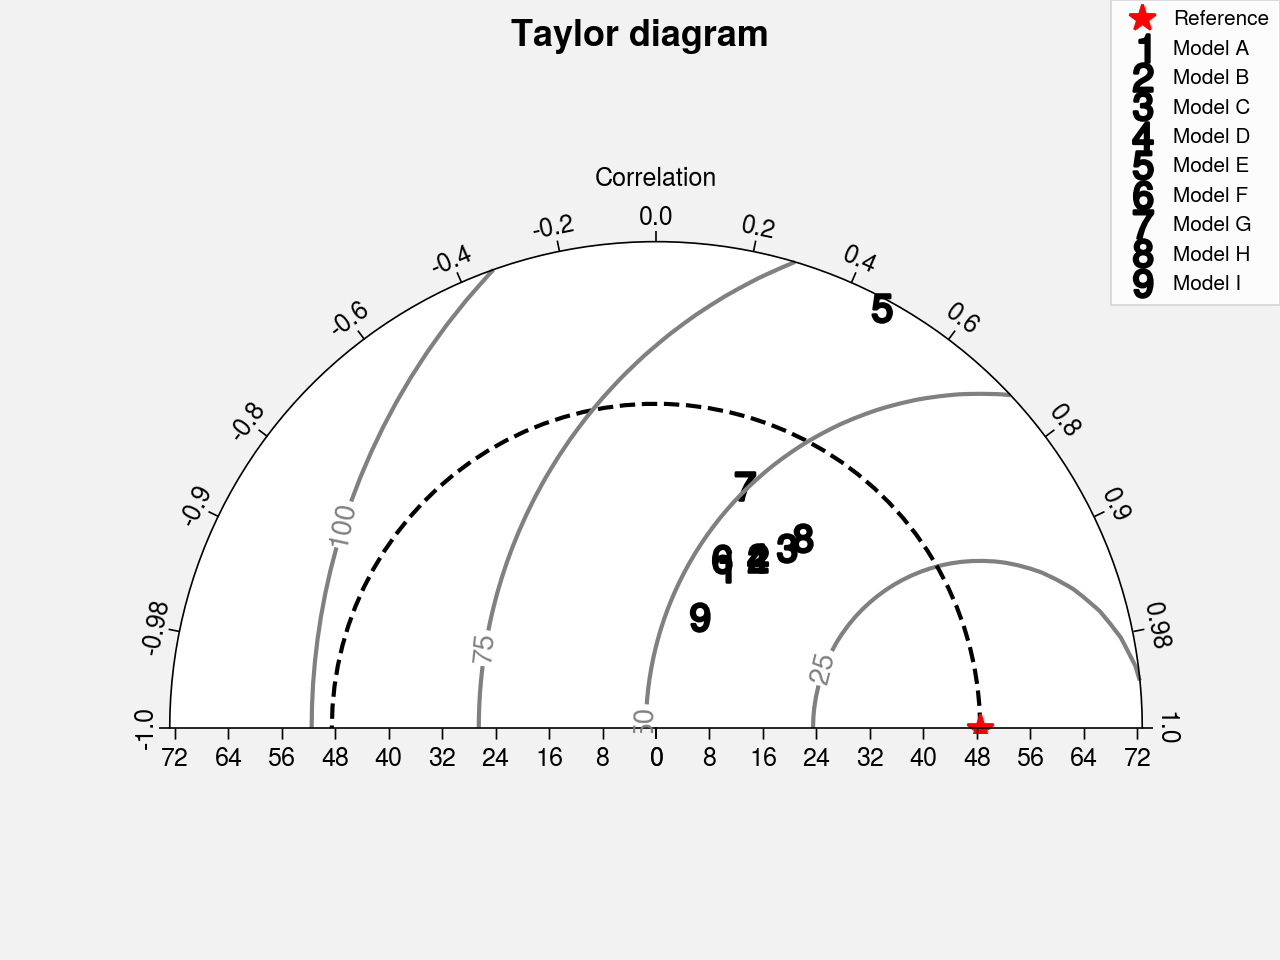

In [49]:
#!/usr/bin/env python
# Copyright: This document has been placed in the public domain.

"""
Taylor diagram (Taylor, 2001) implementation.

Note: If you have found these software useful for your research, I would
appreciate an acknowledgment.
"""

__version__ = "Time-stamp: <2018-12-06 11:43:41 ycopin>"
__author__ = "Yannick Copin <yannick.copin@laposte.net>"

import numpy as NP
import matplotlib.pyplot as PLT


class TaylorDiagram(object):
    """
    Taylor diagram.

    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 1.5), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.

        Parameters:

        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
#         rlocs = NP.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        rlocs = NP.array([0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.98, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = NP.pi
            rlocs = NP.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = NP.pi/2
        tlocs = NP.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = PLT.figure()
        
        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
#         ax.axis["left"].label.set_text("Standard Deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        t = NP.linspace(0, self.tmax)
        r = NP.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(NP.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = NP.meshgrid(NP.linspace(self.smin, self.smax),
                             NP.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = NP.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*NP.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours


def test1():
    """Display a Taylor diagram in a separate axis."""

    # Reference dataset
    x = NP.linspace(0, 4*NP.pi, 100)
    data = NP.sin(x)
    refstd = data.std(ddof=1)           # Reference standard deviation

    # Generate models
    m1 = data + 0.2*NP.random.randn(len(x))     # Model 1
    m2 = 0.8*data + .1*NP.random.randn(len(x))  # Model 2
    m3 = NP.sin(x-NP.pi/10)                     # Model 3

    # Compute stddev and correlation coefficient of models
    samples = NP.array([ [m.std(ddof=1), NP.corrcoef(data, m)[0, 1]]
                         for m in (m1, m2, m3)])

    fig = PLT.figure(figsize=(10, 4))

    ax1 = fig.add_subplot(1, 2, 1, xlabel='X', ylabel='Y')
    # Taylor diagram
#     dia = TaylorDiagram(refstd, fig=fig, rect=(1, 2, 2), label="Reference",
    dia = TaylorDiagram(refstd, fig=fig, rect=122, label="Reference",
                        srange=(0.5, 1.5))

    colors = PLT.matplotlib.cm.jet(NP.linspace(0, 1, len(samples)))

    ax1.plot(x, data, 'ko', label='Data')
    for i, m in enumerate([m1, m2, m3]):
        ax1.plot(x, m, c=colors[i], label='Model %d' % (i+1))
    ax1.legend(numpoints=1, prop=dict(size='small'), loc='best')

    # Add the models to Taylor diagram
    for i, (stddev, corrcoef) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label="Model %d" % (i+1))

    # Add grid
    dia.add_grid()

    # Add RMS contours, and label them
    contours = dia.add_contours(colors='0.5')
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

    # Add a figure legend
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')

    return dia


def test2():
    """
    Climatology-oriented example (after iteration w/ Michael A. Rawlins).
    """

    # Reference std
    stdref = 48.491

    # Samples std,rho,name
    samples = [[25.939, 0.385, "Model A"],
               [29.593, 0.509, "Model B"],
               [33.125, 0.585, "Model C"],
               [29.593, 0.509, "Model D"],
               [71.215, 0.473, "Model E"],
               [27.062, 0.360, "Model F"],
               [38.449, 0.342, "Model G"],
               [35.807, 0.609, "Model H"],
               [17.831, 0.360, "Model I"]]

    fig = PLT.figure()

    dia = TaylorDiagram(stdref, fig=fig, label='Reference', extend=True)
    dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

    # Add models to Taylor diagram
    for i, (stddev, corrcoef, name) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc='k', mec='k',
                       label=name)

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

    # Add a figure legend and title
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')
    fig.suptitle("Taylor diagram", size='x-large')  # Figure title

    return dia


if __name__ == '__main__':

    dia = test1()
    dia = test2()

    PLT.show()

In [50]:
def set_marker(bias):
    if bias > 1:
        marker = '^'
    elif bias < -1:
        marker = 'v'
    else:
        marker = 'o'

    if np.abs(bias) < 1:
        markersize = 6
    elif np.abs(bias) < 3:
        markersize = 8
    elif np.abs(bias) < 5:
        markersize = 10
    elif np.abs(bias) < 7:
        markersize = 12
    else:
        markersize = 14
        
    return marker, markersize

In [54]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def set_legend_handles(legend_handles):
    legend_handles.append(Line2D([0], [0], marker='o', color='w', label='',
                      markerfacecolor='w', markersize=6))

    legend_handles.append(Line2D([0], [0], marker='o', color='w', label='Mean bias',
                      markerfacecolor='w', markersize=6))

    legend_handles.append(Line2D([0], [0], marker='o', color='w', label='-1 to 1 %',
                      markerfacecolor='gray', markersize=6+2))

    legend_handles.append(Line2D([0], [0], marker='^', color='w', label='1 to 3 %',
                      markerfacecolor='gray', markersize=8+2))
    legend_handles.append(Line2D([0], [0], marker='v', color='w', label='-3 to -1 %',
                      markerfacecolor='gray', markersize=8+2))

    legend_handles.append(Line2D([0], [0], marker='^', color='w', label='3 to 5 %',
                      markerfacecolor='gray', markersize=10+2))
    legend_handles.append(Line2D([0], [0], marker='v', color='w', label='-5 to -3 %',
                      markerfacecolor='gray', markersize=10+2))

    legend_handles.append(Line2D([0], [0], marker='^', color='w', label='5 to 7 %',
                      markerfacecolor='gray', markersize=12+2))
    legend_handles.append(Line2D([0], [0], marker='v', color='w', label='-7 to -5 %',
                      markerfacecolor='gray', markersize=12+2))

    legend_handles.append(Line2D([0], [0], marker='^', color='w', label=' > 7 %',
                      markerfacecolor='gray', markersize=14+2))
    legend_handles.append(Line2D([0], [0], marker='v', color='w', label=' < -7 %',
                      markerfacecolor='gray', markersize=14+2))

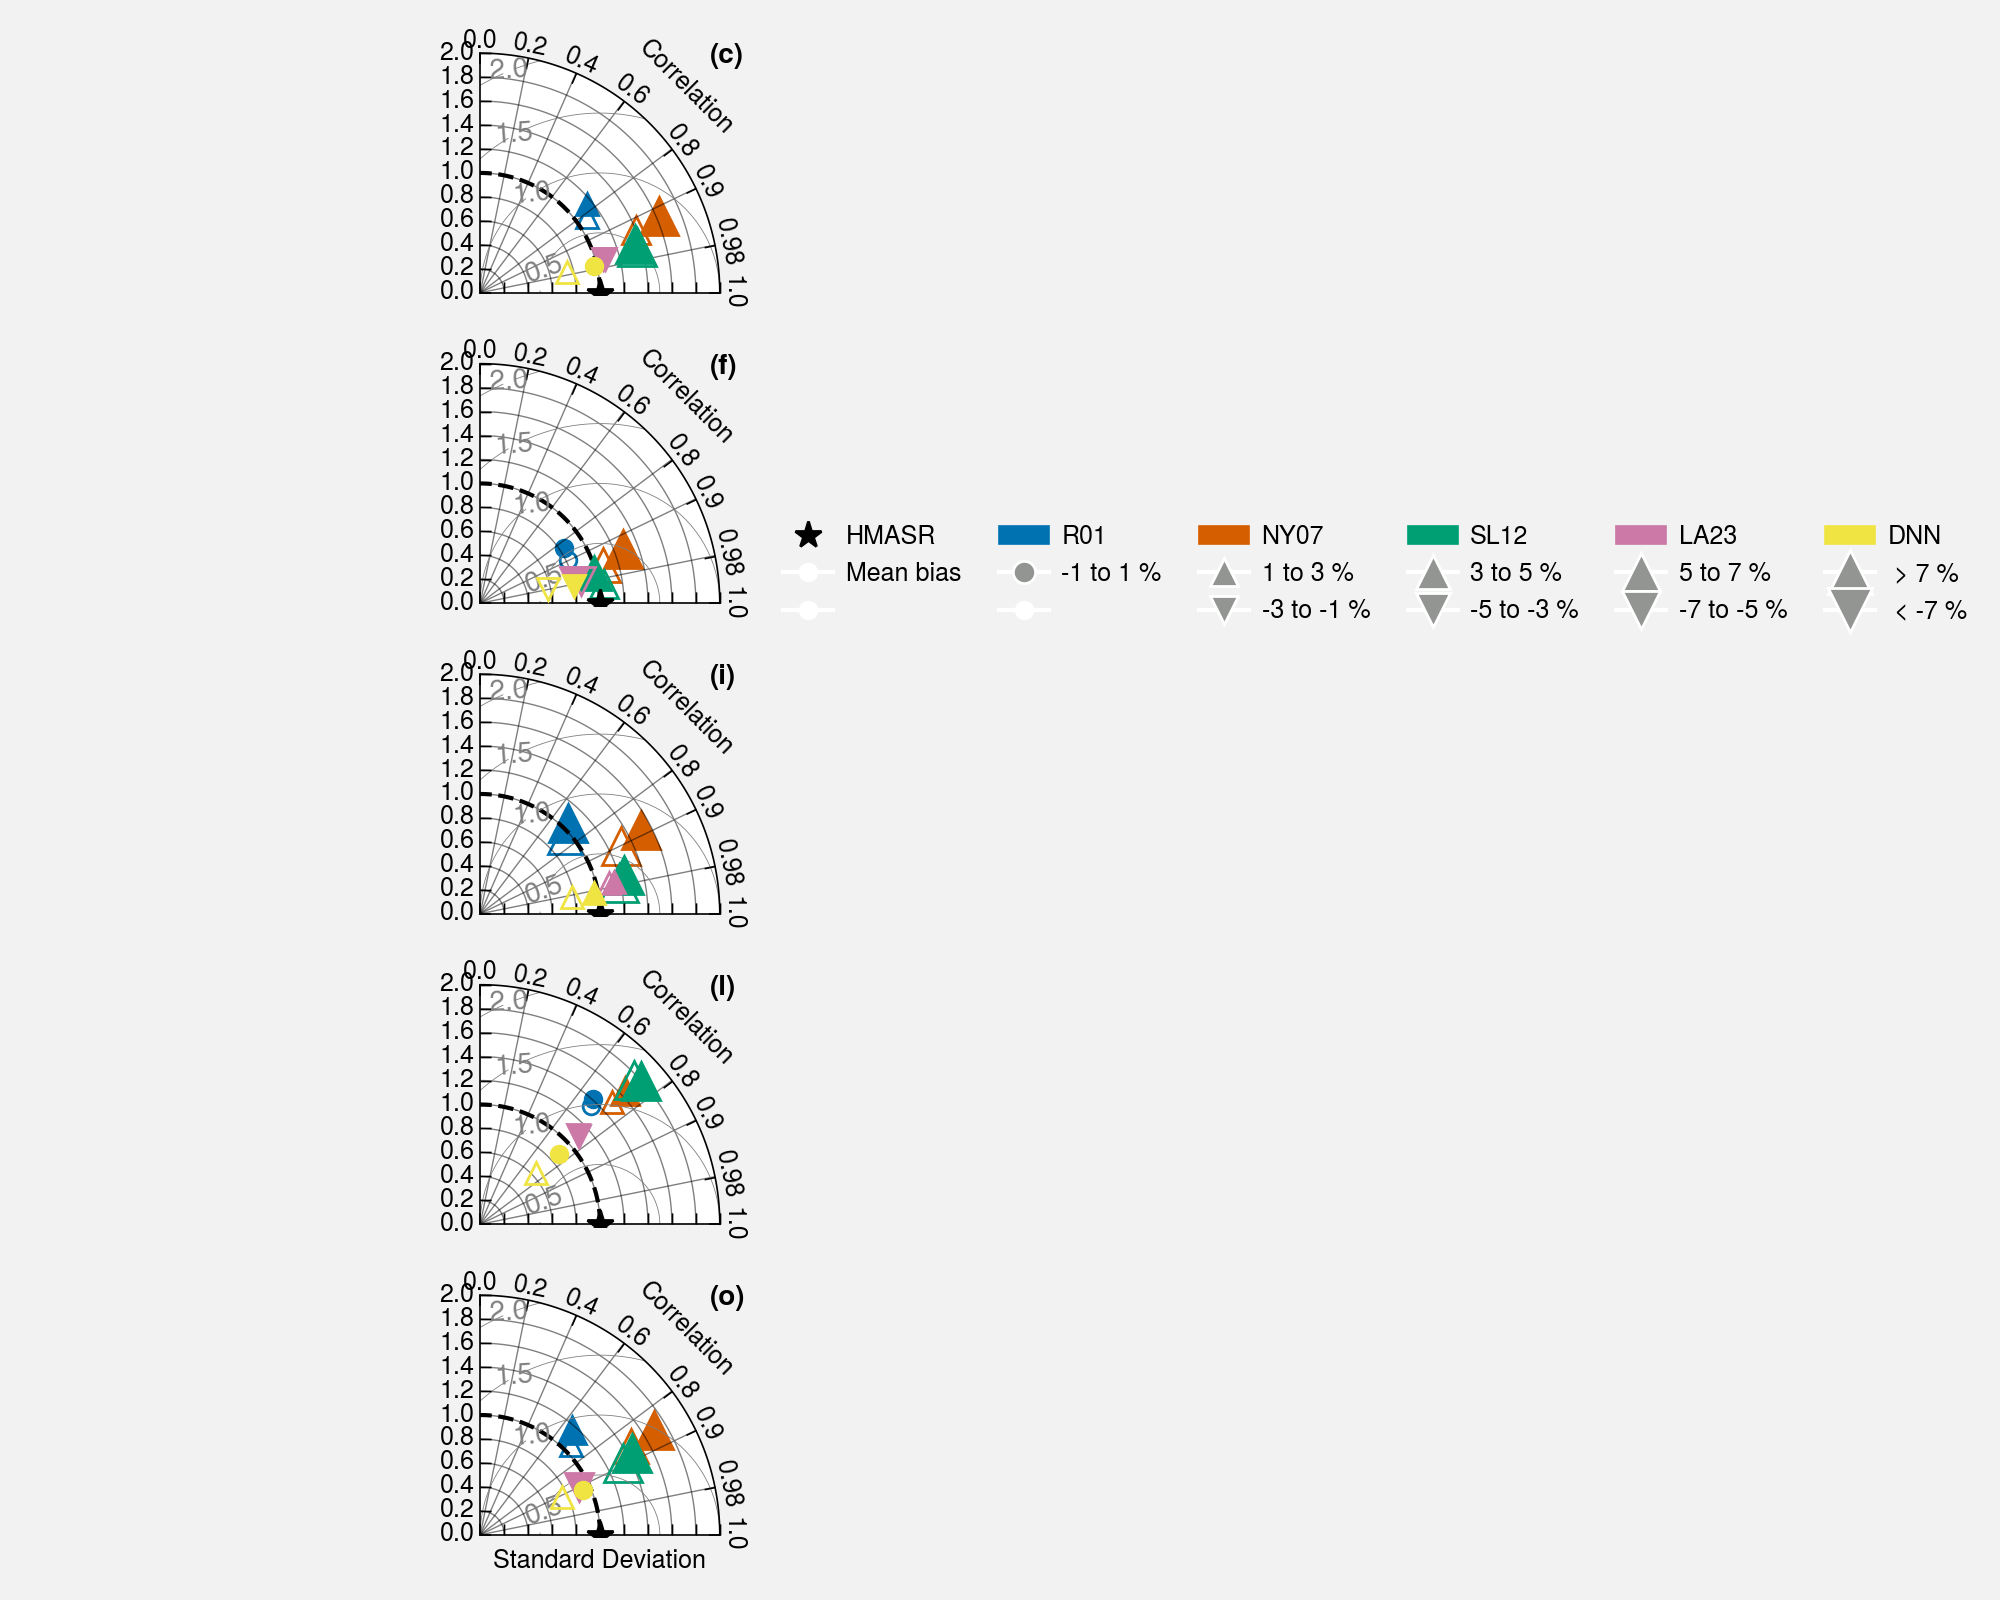

In [63]:
import string 

resolutions = ['val_100', 'val_30']
abc = ['(c)', '(f)', '(i)', '(l)', '(o)']

labels = ['R01', 'NY07', 'SL12', 'LA23', 'DNN']
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

fig = PLT.figure(figsize=(10,8))

k = 1

for zone in zones:
    dia = TaylorDiagram(1, fig=fig, rect=int('51'+str(k)), label='HMASR', srange=(0, 2), extend=False)
    
    for resolution in resolutions:
        std_ref = df_metrics[resolution, 'HMASR'].loc[zone, 'std']

        for i, label in enumerate(labels):

            bias = df_metrics[resolution, label].loc[zone, 'mb']
            marker, markersize = set_marker(bias)

            if resolution == 'val_30':
                mfc = 'none'
            else:
                mfc = colors[i]
            
            dia.add_sample(
                df_metrics[resolution, label].loc[zone, 'std']/std_ref, 
                df_metrics[resolution, label].loc[zone, 'r'], 
                marker=marker, markersize=markersize,
                ms=10, ls='', mfc=mfc, mec=colors[i], label=label, zorder=i
            )

#         if zone == 'HMA':
#             dia._ax.set_title(resolutions[resolution], fontweight="bold")
    dia._ax.text(0.95, 0.95, abc[k-1], size=10, weight='bold', transform=dia._ax.transAxes)
    dia._ax.axis["left"].toggle(ticklabels=False)

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=4, colors='0.5', linewidths=0.3)  # 5 levels in grey
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.1f')

    # Grid
    dia._ax.grid(lw=0.5, alpha=0.5)
    if k == 5:
        dia._ax.axis["left"].label.set_text("Standard Deviation")

    k += 1

legend_handles = [dia.samplePoints[0]]
for color, label in zip(colors, labels):
    legend_handles.append(
        Patch(facecolor=color, edgecolor=color, label=label)
    )
    
# Bias
set_legend_handles(legend_handles)    
    
# fig.legend(handles=legend_handles, ncol=6, bbox_to_anchor=(0.99, 0.68), frameon=False)
fig.legend(handles=[legend_handles[i] for i in [0, 7, 6, 1, 8, 6, 2, 9, 10, 3, 11, 12, 4, 13, 14, 5, 15, 16]], ncol=6, bbox_to_anchor=(0.99, 0.68), frameon=False)

# for zone, y in zip(zones[::-1], np.linspace(0.11, 0.89, len(zones))):
#     fig.text(0.01, y, zone, size=10, weight='bold')
        
fig.tight_layout(rect=[-0.4, 0, 1, 1])
fig.savefig('img/fig07_2.pdf')

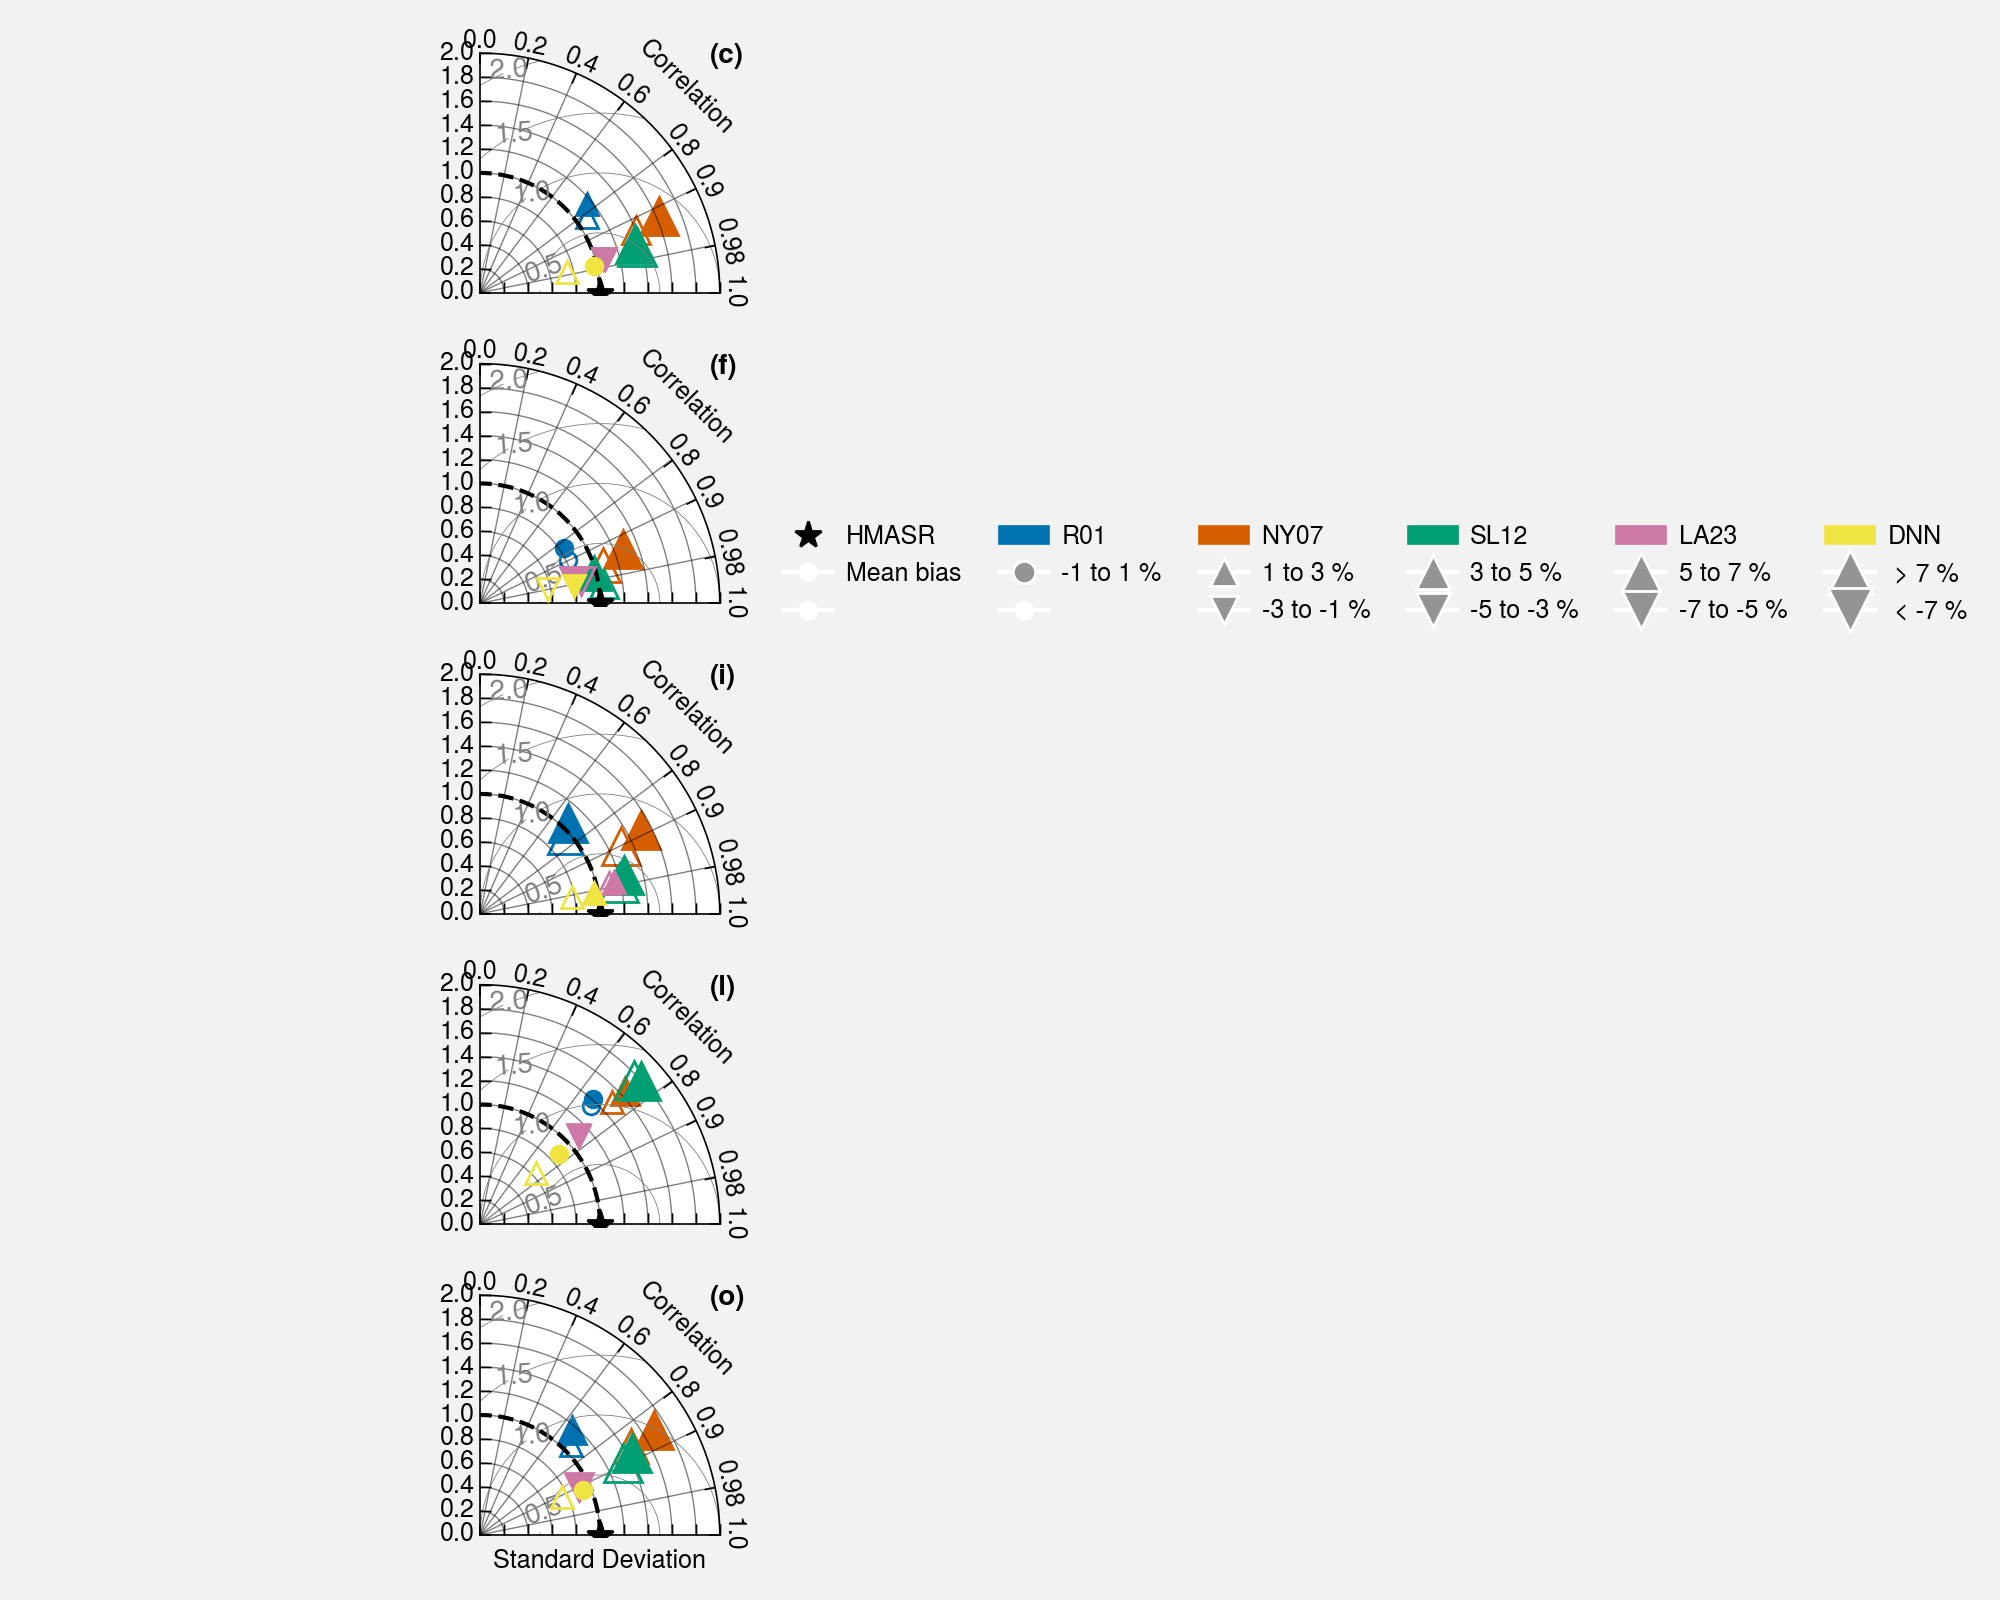

In [58]:
import string 

resolutions = ['val_100', 'val_30']
abc = ['(c)', '(f)', '(i)', '(l)', '(o)']

labels = ['R01', 'NY07', 'SL12', 'LA23', 'DNN']
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

fig = PLT.figure(figsize=(10,8))

k = 1

for zone in zones:
    dia = TaylorDiagram(1, fig=fig, rect=int('51'+str(k)), label='HMASR', srange=(0, 2), extend=False)
    
    for resolution in resolutions:
        std_ref = df_metrics[resolution, 'HMASR'].loc[zone, 'std']

        for i, label in enumerate(labels):

            bias = df_metrics[resolution, label].loc[zone, 'mb']
            marker, markersize = set_marker(bias)

            if resolution == 'val_30':
                mfc = 'none'
            else:
                mfc = colors[i]
            
            dia.add_sample(
                df_metrics[resolution, label].loc[zone, 'std']/std_ref, 
                df_metrics[resolution, label].loc[zone, 'r'], 
                marker=marker, markersize=markersize,
                ms=10, ls='', mfc=mfc, mec=colors[i], label=label, zorder=i
            )

#         if zone == 'HMA':
#             dia._ax.set_title(resolutions[resolution], fontweight="bold")
    dia._ax.text(0.95, 0.95, abc[k-1], size=10, weight='bold', transform=dia._ax.transAxes)
    dia._ax.axis["left"].toggle(ticklabels=False)

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=4, colors='0.5', linewidths=0.3)  # 5 levels in grey
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.1f')

    # Grid
    dia._ax.grid(lw=0.5, alpha=0.5)
    if k == 5:
        dia._ax.axis["left"].label.set_text("Standard Deviation")

    k += 1

legend_handles = [dia.samplePoints[0]]
for color, label in zip(colors, labels):
    legend_handles.append(
        Patch(facecolor=color, edgecolor=color, label=label)
    )
    
# Bias
set_legend_handles(legend_handles)    
    
# fig.legend(handles=legend_handles, ncol=6, bbox_to_anchor=(0.99, 0.68), frameon=False)
fig.legend(handles=[legend_handles[i] for i in [0, 7, 6, 1, 8, 6, 2, 9, 10, 3, 11, 12, 4, 13, 14, 5, 15, 16]], ncol=6, bbox_to_anchor=(0.99, 0.68), frameon=False)

# for zone, y in zip(zones[::-1], np.linspace(0.11, 0.89, len(zones))):
#     fig.text(0.01, y, zone, size=10, weight='bold')
        
fig.tight_layout(rect=[-0.4, 0, 1, 1])
fig.savefig('img/fig07_2.pdf')